In [8]:
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
n_train=50
x_train,_=torch.sort(torch.rand(n_train)*5)

In [10]:
def f(x):
    return 2*torch.sin(x)+x**0.8

y_train=f(x_train)+torch.normal(0.0,0.5,(n_train,))

x_test=torch.arange(0, 5, 0.1)
y_truth=f(x_test)
n_test=len(x_test)
n_test

50

In [11]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

tensor(2.1034)


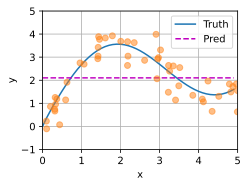

In [12]:
print(y_train.mean())
y_hat=torch.repeat_interleave(y_train.mean(),n_test)
plot_kernel_reg(y_hat)

In [17]:
x_repeat=x_test.repeat_interleave(n_train).reshape(-1,n_train)

attention_weights=nn.functional.softmax(-(x_repeat-x_train)**2/2,dim=1)

x_repeat.shape,x_train.shape,attention_weights.shape


(torch.Size([50, 50]), torch.Size([50]), torch.Size([50, 50]))

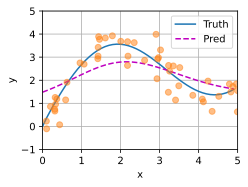

In [14]:
y_hat=torch.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)

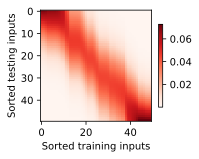

In [18]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [23]:
weights=torch.ones((2,10))*0.1

values=torch.arange(20.0).reshape((2,10))

torch.bmm(weights.unsqueeze(1),values.unsqueeze(-1))

weights.unsqueeze(1).shape,values.unsqueeze(-1).shape

(torch.Size([2, 1, 10]), torch.Size([2, 10, 1]))

In [24]:
class NWKernelRefression(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w=nn.Parameter(torch.rand((1,)),requires_grad=True)

    def forward(self,queries,keys,values):
        queries=queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
        self.attention_weights=nn.functional.softmax(
            -((queries-keys)*self.w)**2/2,dim=1
        )
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)